In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Make sure scikit-learn is on version 1.2.2
# due to this error: https://github.com/scikit-learn/scikit-learn/issues/26768
# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.utils import shuffle
np.random.seed(8)
encoder = LabelEncoder()

In [2]:
# Functions adapted from https://www.kaggle.com/code/gargmanish/basic-machine-learning-with-cancer/notebook
    # model: the learning model
    # train_data: data used to train model
    # test_data: data used to test model
'''
def classification_model(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y)
    predictions = model.predict(train_x)
    accuracy = metrics.accuracy_score(predictions, train_y)
    print("Accuracy on training data: %s" % "{0:.3%}".format(accuracy))
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(train_x)
    error = []
    for i, (train, test) in enumerate(kf.split(train_x)):
        fold_x = train_x.iloc[train, :]
        fold_y = train_y.iloc[train]
        model.fit(fold_x, fold_y)
        
        fold_test_x = train_x.iloc[test, :]
        fold_test_y = train_y.iloc[test]
        error.append(model.score(fold_test_x, fold_test_y))
        print(f'Fold: {i}')
        print(" Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
    
    test_score = model.score(test_x, test_y)
    print("Test Set Score: %s" % "{0:.3%}".format(test_score))
'''

def classification_model(model, train_x, train_y, title, fname):
    # Generate the learning curve data points
    train_sizes, train_scores, test_scores = learning_curve(model, train_x, train_y, cv=5, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title(title)
    plt.savefig(fname=fname)
    print('Training Scores:')
    print(train_scores_mean)
    print('CV Scores:')
    print(test_scores_mean)

def classification_model_gridsearchCV(model, param_grid, data_X, data_Y, test_x, test_y):
    clf = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
    clf.fit(data_X, data_Y)
    print("The best parameters found:")
    print(clf.best_params_)
    print("The best estimator:")
    print(clf.best_estimator_)
    print("The best score on the training data is: {0:.3%}".format(clf.best_score_))
    best_model = clf.best_estimator_
    print("Test set score with the best model: %s" % "{0:.3%}".format(best_model.score(test_X, test_Y)))

# Dataset 1: Wisconsin Breast Cancer Diagnostic Dataset
- Source: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download

In [3]:
# Reading data and preprocessing
data = pd.read_csv('data/breast_cancer_data.csv')

# 'id' column doesn't provide useful information
# 'Unnamed: 32' column contains NaN values
data.drop(columns=['id', 'Unnamed: 32'], inplace=True)

# Split the data
train, test = train_test_split(data, test_size=0.3)
train_X = train.drop(columns='diagnosis')
train_Y = pd.DataFrame(encoder.fit_transform(train['diagnosis']))
test_X = test.drop(columns='diagnosis')
test_Y = pd.DataFrame(encoder.fit_transform(test['diagnosis']))
data.shape

(569, 31)

### Dataset 1: Decision Tree Classifier

Training Scores:
[1. 1. 1. 1. 1.]
CV Scores:
[0.90689873 0.89449367 0.89427215 0.90436709 0.90689873]


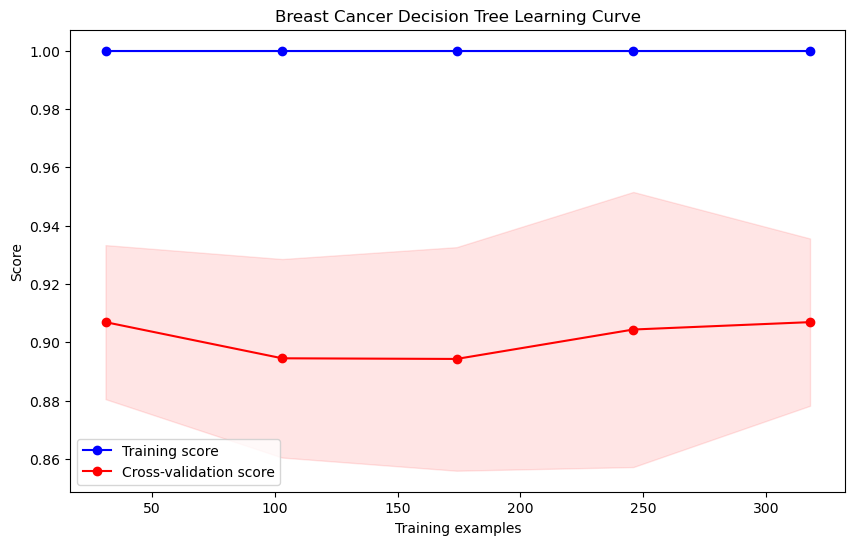

In [4]:
model = DecisionTreeClassifier()
classification_model(model, train_X, train_Y, 'Breast Cancer Decision Tree Learning Curve', 'd1_dt.png')

In [5]:
param_grid = {'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2,3,4,5,6,7,8,9,10], 
              'min_samples_leaf':[2,3,4,5,6,7,8,9,10],
              'criterion': ['gini', 'entropy']}
classification_model_gridsearchCV(model, param_grid, train_X, train_Y, test_X, test_Y)

The best parameters found:
{'criterion': 'entropy', 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}
The best estimator:
DecisionTreeClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=2)
The best score on the training data is: 95.468%
Test set score with the best model: 91.228%


### Dataset 1: Neural Network

Training Scores:
[1.         0.73786408 0.85057471 0.9300813  0.93018868]
CV Scores:
[0.90449367 0.68952532 0.82718354 0.90202532 0.92971519]


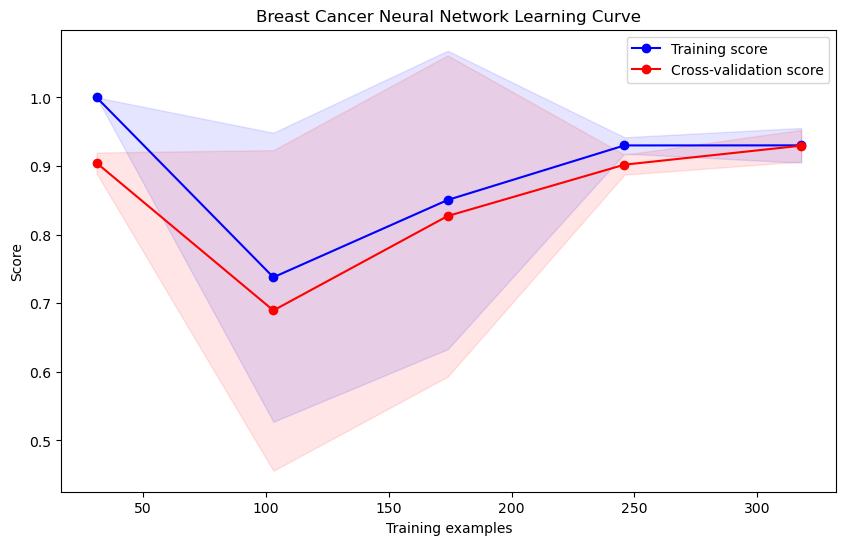

In [6]:
model = MLPClassifier(max_iter=1500)
classification_model(model, train_X, np.ravel(train_Y), 'Breast Cancer Neural Network Learning Curve', 'd1_nn.png')

In [7]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}
best_model = classification_model_gridsearchCV(model, param_grid, train_X, np.ravel(train_Y), test_X, np.ravel(test_Y))

The best parameters found:
{'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
The best estimator:
MLPClassifier(hidden_layer_sizes=(50,), max_iter=1500)
The best score on the training data is: 93.968%
Test set score with the best model: 95.322%


### Dataset 1: k-nearest neighbors

Training Scores:
[0.92258065 0.89902913 0.93563218 0.9398374  0.9408805 ]
CV Scores:
[0.86924051 0.90949367 0.92708861 0.93968354 0.92962025]


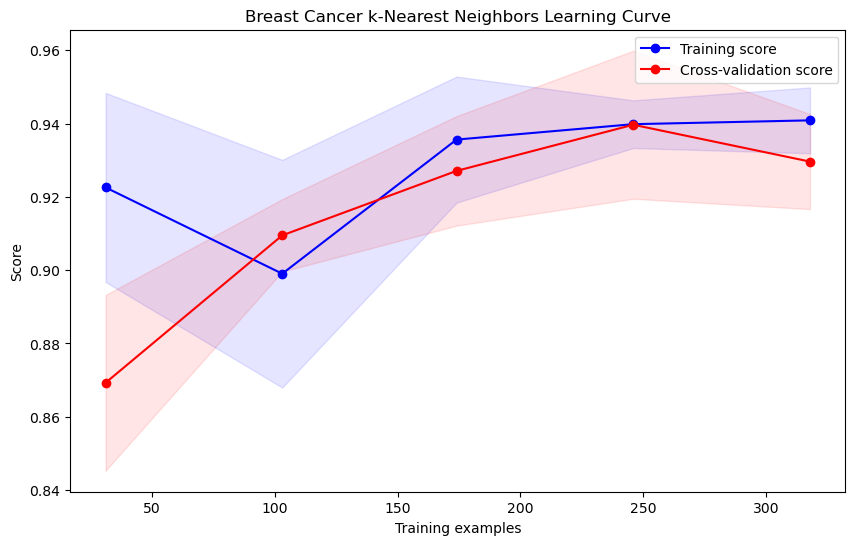

In [8]:
model = KNeighborsClassifier()
classification_model(model, train_X, np.ravel(train_Y), 'Breast Cancer k-Nearest Neighbors Learning Curve', 'd1_knn.png')

In [9]:
param_grid = {
    'n_neighbors': [i for i in range(1,21)],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}
classification_model_gridsearchCV(model, param_grid, train_X, np.ravel(train_Y), test_X, np.ravel(test_Y))

The best parameters found:
{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
The best estimator:
KNeighborsClassifier(n_neighbors=7, p=1)
The best score on the training data is: 93.968%
Test set score with the best model: 95.322%


### Dataset 1: Boosting


Training Scores:
[1. 1. 1. 1. 1.]
CV Scores:
[0.91696203 0.93708861 0.95974684 0.96471519 0.96484177]


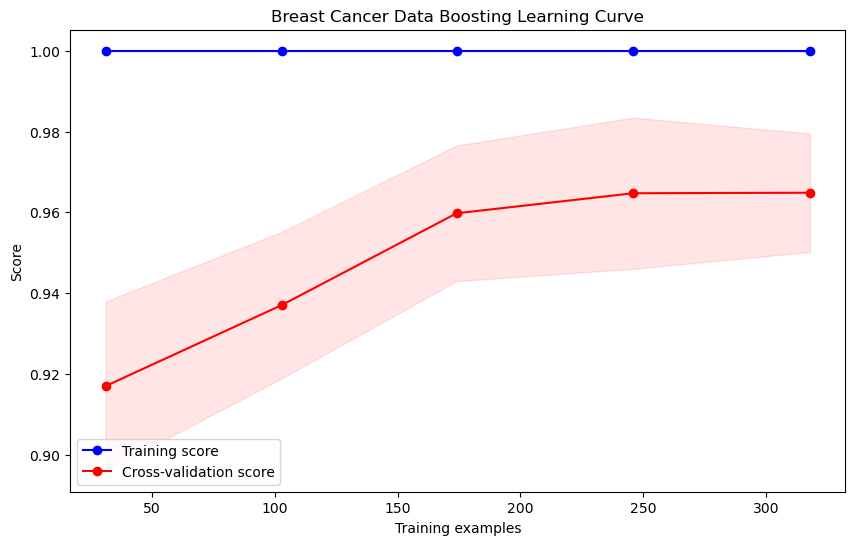

In [10]:
model = AdaBoostClassifier()
classification_model(model, train_X, np.ravel(train_Y), 'Breast Cancer Data Boosting Learning Curve', 'd1_boost.png')

In [11]:
param_grid = {
    'n_estimators': [10, 50, 250, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7, 1.0],
}
classification_model_gridsearchCV(model, param_grid, train_X, np.ravel(train_Y), test_X, np.ravel(test_Y))

The best parameters found:
{'learning_rate': 1.0, 'n_estimators': 1000}
The best estimator:
AdaBoostClassifier(n_estimators=1000)
The best score on the training data is: 97.744%
Test set score with the best model: 98.246%


### Dataset 1: SVM

Training Scores:
[0.92258065 0.88349515 0.90689655 0.9097561  0.91132075]
CV Scores:
[0.86670886 0.8818038  0.89436709 0.90443038 0.90443038]


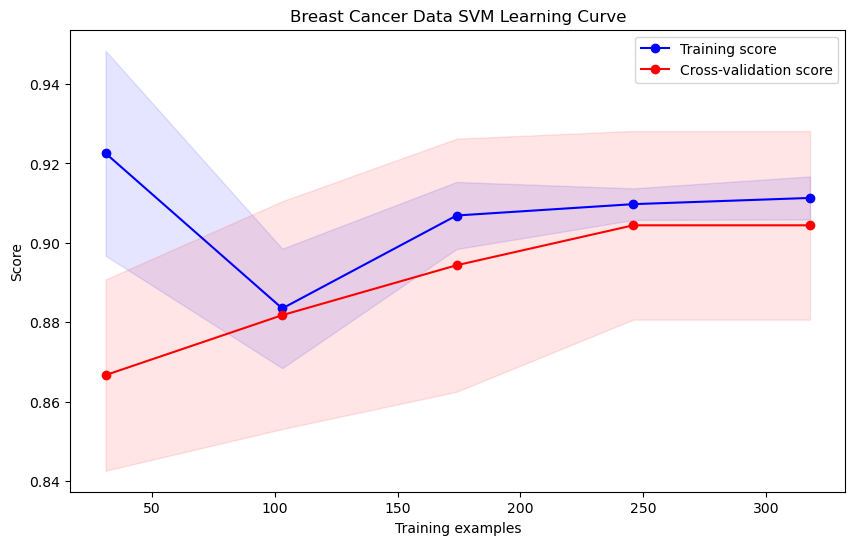

In [12]:
model = SVC()
classification_model(model, train_X, np.ravel(train_Y), 'Breast Cancer Data SVM Learning Curve', 'd1_svm.png')

In [13]:
param_grid = {
    'C': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'gamma': ['scale', 'auto'],
    'kernel': ['sigmoid', 'rbf'],
}
classification_model_gridsearchCV(model, param_grid, train_X, np.ravel(train_Y), test_X, np.ravel(test_Y))

The best parameters found:
{'C': 1000.0, 'gamma': 'scale', 'kernel': 'rbf'}
The best estimator:
SVC(C=1000.0)
The best score on the training data is: 94.212%
Test set score with the best model: 96.491%


# Dataset 2: Iris Species

In [14]:
data = pd.read_csv('data/Iris.csv')
data = data.drop(columns='Id')
data = data.sample(frac=1)
train, test = train_test_split(data, test_size=0.3)
data.head()
train_X = train.drop(columns='Species')
train_Y = train['Species']
test_X = test.drop(columns='Species')
test_Y = test['Species']

### Dataset 2: DecisionTreeClassifier

Training Scores:
[1. 1. 1. 1. 1.]
CV Scores:
[0.92380952 0.96190476 0.94285714 0.93333333 0.93333333]


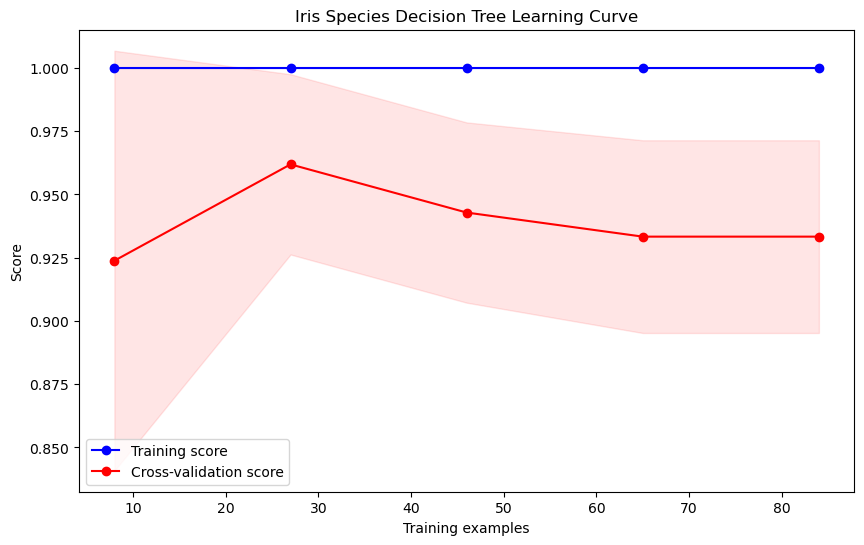

In [15]:
model = DecisionTreeClassifier()
classification_model(model, train_X, train_Y, 'Iris Species Decision Tree Learning Curve', 'd2_dt.png')

In [16]:
param_grid = {'max_features': ['sqrt', 'log2'],
              'min_samples_split': [2,3,4,5,6,7,8,9,10], 
              'min_samples_leaf':[2,3,4,5,6,7,8,9,10],
              'criterion': ['gini', 'entropy']}
classification_model_gridsearchCV(model, param_grid, train_X, train_Y, test_X, test_Y)

The best parameters found:
{'criterion': 'gini', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 4}
The best estimator:
DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=4)
The best score on the training data is: 96.182%
Test set score with the best model: 95.556%


### Dataset 2: Neural Network

Training Scores:
[1.         1.         1.         0.99076923 0.99047619]
CV Scores:
[0.95238095 0.97142857 0.97142857 0.98095238 0.99047619]


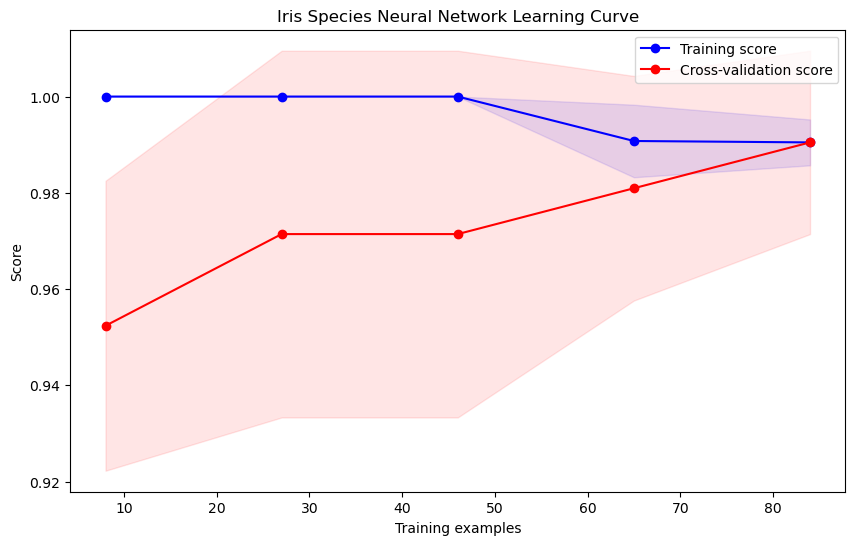

In [17]:
model = MLPClassifier(max_iter=1500)
classification_model(model, train_X, train_Y, 'Iris Species Neural Network Learning Curve', 'd2_nn.png')

In [18]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}
best_model = classification_model_gridsearchCV(model, param_grid, train_X, train_Y, test_X, test_Y)

The best parameters found:
{'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant'}
The best estimator:
MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1500)
The best score on the training data is: 99.000%
Test set score with the best model: 93.333%


### Dataset 2: k-nearest neighbors

Training Scores:
[0.625      0.94074074 0.97826087 0.97230769 0.97142857]
CV Scores:
[0.34285714 0.96190476 0.97142857 0.97142857 0.96190476]


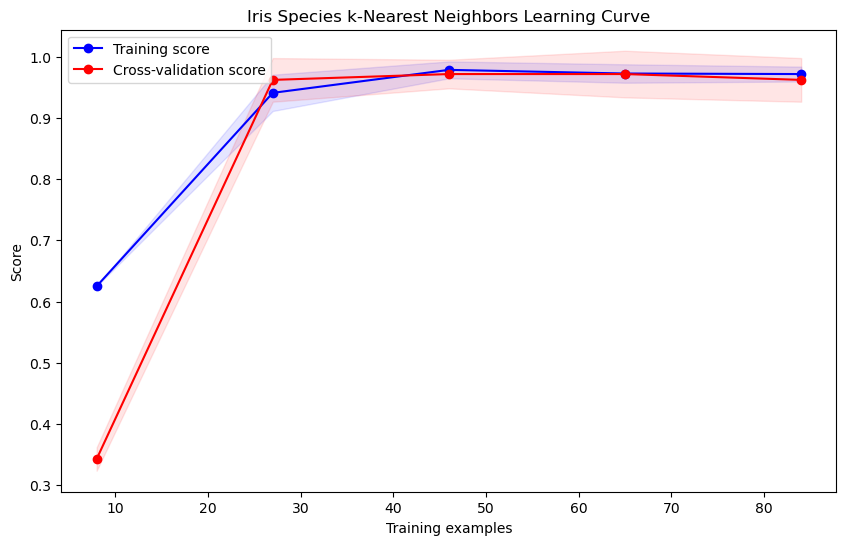

In [19]:
model = KNeighborsClassifier()
classification_model(model, train_X, train_Y, 'Iris Species k-Nearest Neighbors Learning Curve', 'd2_knn.png')

In [20]:
param_grid = {
    'n_neighbors': [i for i in range(1, 21)],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}
classification_model_gridsearchCV(model, param_grid, train_X, train_Y, test_X, test_Y)

The best parameters found:
{'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
The best estimator:
KNeighborsClassifier(n_neighbors=8, weights='distance')
The best score on the training data is: 97.182%
Test set score with the best model: 93.333%


### Dataset 2: Boosting

Training Scores:
[1.         1.         1.         0.99692308 0.97380952]
CV Scores:
[0.8952381  0.96190476 0.97142857 0.93333333 0.91428571]


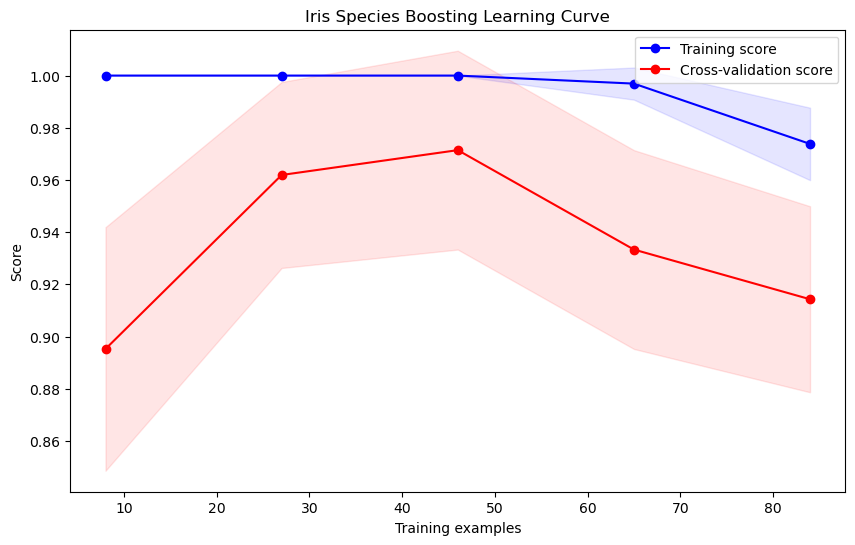

In [21]:
model = AdaBoostClassifier()
classification_model(model, train_X, train_Y, 'Iris Species Boosting Learning Curve', 'd2_boost.png')

In [22]:
param_grid = {
    'n_estimators': [10, 50, 250, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7, 1.0],
}
classification_model_gridsearchCV(model, param_grid, train_X, train_Y, test_X, test_Y)

The best parameters found:
{'learning_rate': 0.01, 'n_estimators': 10}
The best estimator:
AdaBoostClassifier(learning_rate=0.01, n_estimators=10)
The best score on the training data is: 94.273%
Test set score with the best model: 95.556%


### Dataset 2: SVM

Training Scores:
[0.875      0.93333333 0.96956522 0.96615385 0.96904762]
CV Scores:
[0.68571429 0.94285714 0.96190476 0.95238095 0.95238095]


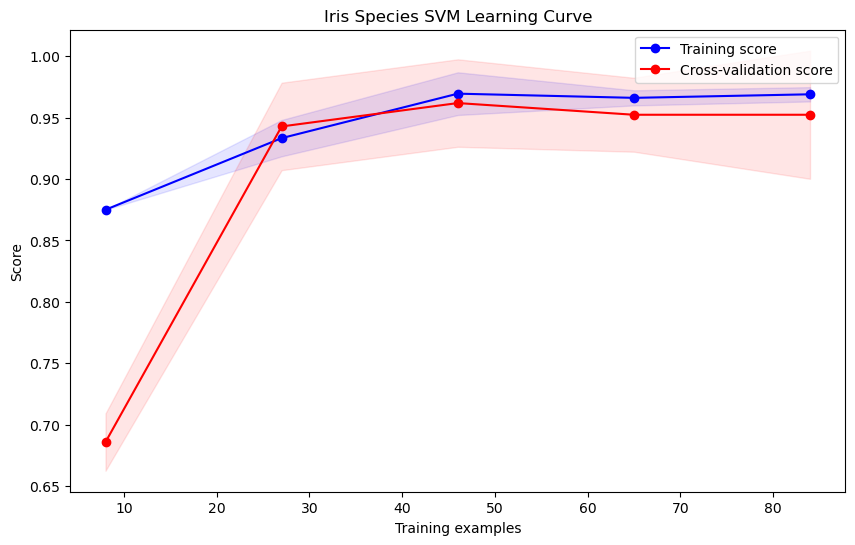

In [23]:
model = SVC()
classification_model(model, train_X, train_Y, 'Iris Species SVM Learning Curve', 'd2_svm.png')

In [24]:
param_grid = {
    'C': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'gamma': ['scale', 'auto'],
    'kernel': ['sigmoid', 'rbf'],
}
classification_model_gridsearchCV(model, param_grid, train_X, train_Y, test_X, test_Y)

The best parameters found:
{'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}
The best estimator:
SVC(C=100.0)
The best score on the training data is: 99.000%
Test set score with the best model: 95.556%
